['MMM', 'ABT', 'ABBV', 'ABMD', 'ACN', 'ATVI', 'ADBE', 'AMD', 'AAP', 'AES', 'AMG', 'AFL', 'A', 'APD', 'AKAM', 'ALK', 'ALB', 'ARE', 'ALXN', 'ALGN', 'ALLE', 'AGN', 'ADS', 'LNT', 'ALL', 'GOOGL', 'GOOG', 'MO', 'AMZN', 'AEE', 'AAL', 'AEP', 'AXP', 'AIG', 'AMT', 'AWK', 'AMP', 'ABC', 'AME', 'AMGN', 'APH', 'APC', 'ADI', 'ANSS', 'ANTM', 'AON', 'AOS', 'APA', 'AIV', 'AAPL', 'AMAT', 'APTV', 'ADM', 'ARNC', 'ANET', 'AJG', 'AIZ', 'ATO', 'T', 'ADSK', 'ADP', 'AZO', 'AVB', 'AVY', 'BHGE', 'BLL', 'BAC', 'BK', 'BAX', 'BBT', 'BDX', 'BRK-B', 'BBY', 'BIIB', 'BLK', 'HRB', 'BA', 'BKNG', 'BWA', 'BXP', 'BSX', 'BHF', 'BMY', 'AVGO', 'BR', 'BF-B', 'CHRW', 'COG', 'CDNS', 'CPB', 'COF', 'CPRI', 'CAH', 'KMX', 'CCL', 'CAT', 'CBOE', 'CBRE', 'CBS', 'CE', 'CELG', 'CNC', 'CNP', 'CTL', 'CERN', 'CF', 'SCHW', 'CHTR', 'CVX', 'CMG', 'CB', 'CHD', 'CI', 'XEC', 'CINF', 'CTAS', 'CSCO', 'C', 'CFG', 'CTXS', 'CLX', 'CME', 'CMS', 'KO', 'CTSH', 'CL', 'CMCSA', 'CMA', 'CAG', 'CXO', 'COP', 'ED', 'STZ', 'COO', 'CPRT', 'GLW', 'COST', 'COTY', 'CC

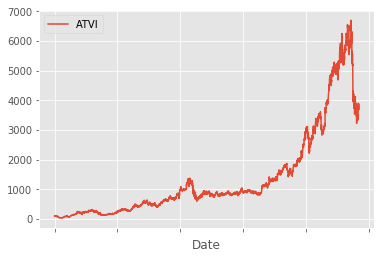

In [28]:
# %load Dataproject.py
#First pass
"""
write this in the Terminal:
pip install https://github.com/matplotlib/mpl_finance/archive/master.zip

And this:
conda install -c anaconda pandas-datareader

When asked:
The following packages will be SUPERSEDED by a higher-priority channel:

  ca-certificates                                 pkgs/main --> anaconda
  certifi                                         pkgs/main --> anaconda
  openssl                                         pkgs/main --> anaconda
  qt                                              pkgs/main --> anaconda
Proceed ([y]/n)?

Press y
"""
import datetime as dt
import matplotlib.pyplot as plt
from matplotlib import style
from mpl_finance import candlestick_ohlc
import matplotlib.dates as mdates
import pandas as pd
import pandas_datareader as web
import numpy as np
import bs4 as bs
import pickle
import requests
import os
import pickle
import numpy as np
from scipy.stats import norm # normal distribution
import matplotlib.pyplot as plt
import ipywidgets as widgets
style.use("ggplot")


#Automating S&P500 - From Yahoo Finance - Close price adjusted for splits, and Adj. Close price is adjusted for both dividends and splits.
def save_sp500_tickers():
    resp = requests.get("https://en.wikipedia.org/wiki/List_of_S%26P_500_companies")
    soup = bs.BeautifulSoup(resp.text, "lxml")
    table = soup.find("table", {"class": "wikitable sortable"})
    tickers = []
    for row in table.findAll("tr")[1:]:
        ticker = row.findAll("td")[1].text.replace(".","-")
        tickers.append(ticker)

    with open("sp500tickers.pickle", "wb") as f:
        pickle.dump(tickers, f)
    
        print(tickers)

        return(tickers)
    

save_sp500_tickers()


#Getting data from Yahoo
def data_yahoo(reload_sp500=False):
    if reload_sp500:
        tickers = save_sp500_tickers()
    else:
        with open("sp500tickers.pickle", "rb") as f:
            tickers = pickle.load(f)
    if not os.path.exists('stock_dfs'):
        os.makedirs('stock_dfs')

    start = dt.datetime(2000, 1, 1)
    end = dt.datetime.now()
    for ticker in tickers:
        # just in case your connection breaks, we'd like to save our progress!
        if not os.path.exists('stock_dfs/{}.csv'.format(ticker)):
            df = web.DataReader(ticker, 'yahoo', start, end)
            df.to_csv('stock_dfs/{}.csv'.format(ticker))
        else:
            print('Already have {}'.format(ticker))

data_yahoo()


def compile_data():
    with open("sp500tickers.pickle", "rb") as f:
        tickers = pickle.load(f)

    main_df = pd.DataFrame()

    #Iterating though all DFs

    for count, ticker in enumerate(tickers):
        df = pd.read_csv("stock_dfs/{}.csv".format(ticker))
        df.set_index("Date", inplace=True)
        df.rename(columns = {"Adj Close": ticker}, inplace=True) #Adj Close takes the categories place in the column - Simple rename
        df.drop(["Open","High","Low","Close","Volume"],1, inplace=True)
        df = df.divide(df.iloc[0])*100

        if main_df.empty:
            main_df = df
        else:
            main_df = main_df.join(df, how="outer")
        
        if count % 10 == 0: #Only print #10, #20, #30, etc.
            print(count)
    print(main_df.head())
    main_df.to_csv("sp500_joined_adj_closes.csv")

compile_data()

df_stocks = pd.read_csv("sp500_joined_adj_closes.csv")
df_stocks.set_index("Date", inplace=True)

print(df_stocks)

#Get sp500 index data

Index_data = web.DataReader("^GSPC", data_source="yahoo", start="1,1,2000")
Index_data.to_csv("IndexData.csv")

df_index_data = pd.read_csv("IndexData.csv", parse_dates=True)
df_index_data.set_index("Date", inplace=True)
df_index_data.rename(columns = {"Adj Close": "S&P500"}, inplace=True)

df_index_data_new = df_index_data["S&P500"]
print(df_index_data_new)

df_index_data_new = df_index_data_new/df_index_data_new[0]*100
print(df_index_data_new)
df_index_data_new.plot()

df_final = df_stocks.join(df_index_data_new, how="left")
print(df_final)

#Widget/plot

with open("sp500tickers.pickle", "rb") as f:
    tickers = pickle.load(f)


%matplotlib inline
df_final["ATVI"].plot(legend=True)
